In [1]:
import time
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from utils import *

In [2]:
def get_dataloaders_cifar10_selfsupervised(batch_size, num_workers=0,
                            validation_fraction=None,
                            train_transforms=None,
                            test_transforms=None,
                            mode = 'supervised'):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()
    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.CIFAR10(root='data',
                                    train=True,
                                    transform=train_transforms,
                                    download=True)
    valid_dataset = datasets.CIFAR10(root='data',
                                    train=True,
                                    transform=test_transforms)
    test_dataset = datasets.CIFAR10(root='data',
                                    train=False,
                                    transform=test_transforms)

    if mode == 'supervised':
        num = int(validation_fraction * 50000)
        train_indices = torch.arange(0, 50000 - num)
        valid_indices = torch.arange(50000 - num, 50000)
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)
        valid_loader = DataLoader(dataset=valid_dataset,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                sampler=valid_sampler)
        train_loader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                drop_last=True,
                                sampler=train_sampler)
        test_loader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                shuffle=False)
        return train_loader, valid_loader, test_loader

    elif mode == 'self-supervised':
        num = int(validation_fraction * 50000)
        valid_indices = torch.arange(50000 - num, 50000)
        train_indices = torch.arange(0, 50000 - num)
        
        train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
        valid_dataset = torch.utils.data.Subset(valid_dataset, valid_indices)

        train_unlabelled_indices, train_labelled_indices = train_test_split(list(range(len(train_dataset))), test_size=5000)
        train_unlabelled_dataset = torch.utils.data.Subset(train_dataset, train_unlabelled_indices)
        train_labelled_dataset = torch.utils.data.Subset(train_dataset, train_labelled_indices)
        valid_loader = DataLoader(dataset=valid_dataset,
                                batch_size=batch_size,
                                num_workers=num_workers)

        train_labelled_loader = DataLoader(dataset=train_labelled_dataset,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                drop_last=True)
        train_unlabelled_loader = DataLoader(dataset=train_unlabelled_dataset,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                drop_last=True)
        test_loader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                shuffle=False)

        return train_labelled_loader, train_unlabelled_loader, valid_loader, test_loader

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

BATCH_SIZE = 256

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For Supervised
train_transforms, test_transforms = None, None
train_labelled_loader, train_unlabelled_loader, valid_loader, test_loader = get_dataloaders_cifar10_selfsupervised(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2, mode = 'self-supervised')

train_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
train_labelled_loader_flatten, train_unlabelled_loader_flatten, valid_loader_flatten, test_loader_flatten = get_dataloaders_cifar10_selfsupervised(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2, mode = 'self-supervised')

for images, labels in train_labelled_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    print()
    break

for images, labels in train_labelled_loader_flatten:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    print()
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([1, 9, 4, 3, 9, 1, 5, 5, 1, 6])

Image batch dimensions: torch.Size([256, 3072])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([0, 5, 2, 3, 6, 2, 9, 9, 9, 7])



In [4]:
def train_model_selfsupervised(model, num_epochs, train_loader_lst,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):
    train_loader, train_unlabelled_loader = train_loader_lst
    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    cnt = 0
    predicted_labels_dict = {}
    for epoch in range(num_epochs):

        model.train()
        
        if cnt > 0:
            for batch_idx, (features, targets) in itertools.islice(enumerate(train_unlabelled_loader), 0, (cnt)*BATCH_SIZE, 1):
                features = features.to(device)
                targets = targets.float().to(device)

                logits = model(features)
                _, predicted_labels = torch.max(logits, 1)

                targets = predicted_labels_dict[batch_idx].to(device)

                # ## FORWARD AND BACK PROP
                logits = model(features)
                loss = torch.nn.functional.cross_entropy(logits, targets)
                optimizer.zero_grad()

                loss.backward()

                # ## UPDATE MODEL PARAMETERS
                optimizer.step()

                # ## LOGGING
                minibatch_loss_list.append(loss.item())
                if not batch_idx % logging_interval:
                    print(f'Self-Supervised '
                        f'| Batch {batch_idx:04d}/{len(train_unlabelled_loader):04d} '
                        f'| Loss: {loss:.4f}')
            predicted_labels_dict = {}

        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        for batch_idx, (features, targets) in itertools.islice(enumerate(train_unlabelled_loader), 0, (cnt+1)*BATCH_SIZE, 1):
            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            targets = predicted_labels.to(device)
            predicted_labels_dict[batch_idx] = targets

        cnt+=1

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

In [5]:
def start_train_selfsupervised(model, device, NUM_EPOCHS, data_loader, lr = 0.001, FileName = 'model'):
    train_labelled_loader, train_unlabelled_loader, valid_loader, test_loader = data_loader
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        factor=0.1,
                                                        mode='max',
                                                        verbose=True)

    minibatch_loss_list, train_acc_list, valid_acc_list = train_model_selfsupervised(
        model=model,
        num_epochs=NUM_EPOCHS,
        train_loader_lst=[train_labelled_loader, train_unlabelled_loader],
        valid_loader=valid_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        device=device,
        scheduler=scheduler,
        scheduler_on='valid_acc',
        logging_interval=100)

    plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                    num_epochs=NUM_EPOCHS,
                    iter_per_epoch=len(train_labelled_loader),
                    results_dir=None,
                    averaging_iterations=200)
    plt.show()

    plot_accuracy(train_acc_list=train_acc_list,
                valid_acc_list=valid_acc_list,
                results_dir=None)
    # plt.ylim([60, 100])
    plt.show()

    class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}
    mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=device)
    plot_confusion_matrix(mat, class_names=class_dict.values())
    plt.show()

    torch.save(model.state_dict(), f'{FileName}_selfsupervised.ckpt')
    return compute_accuracy(model, test_loader, device=device).to('cpu').numpy()

In [6]:
model_vgg = VGG16(num_classes=10)
model_resnet = ResNet(ResidualBlock, [2, 2, 2]).to(device)
model_mlp = MultilayerPerceptron()

In [7]:
test_acc_lst = {'vgg':[],'resnet':[],'mlp':[]}

*************************************************************************************
Model: vgg, lr: 0.0001
*************************************************************************************
Epoch: 001/010 | Batch 0000/0019 | Loss: 2.7646
Epoch: 001/010 | Train: 10.67% | Validation: 9.76%
Time elapsed: 0.11 min
Self-Supervised | Batch 0000/0156 | Loss: 2.4224
Self-Supervised | Batch 0100/0156 | Loss: 2.2944
Epoch: 002/010 | Batch 0000/0019 | Loss: 2.3093
Epoch: 002/010 | Train: 10.63% | Validation: 9.76%
Time elapsed: 0.43 min
Self-Supervised | Batch 0000/0156 | Loss: 2.1805
Self-Supervised | Batch 0100/0156 | Loss: 1.7741
Epoch: 003/010 | Batch 0000/0019 | Loss: 2.6903
Epoch: 003/010 | Train: 10.63% | Validation: 9.76%
Time elapsed: 0.73 min
Self-Supervised | Batch 0000/0156 | Loss: 1.6958
Self-Supervised | Batch 0100/0156 | Loss: 0.2639
Epoch: 004/010 | Batch 0000/0019 | Loss: 5.4921
Epoch: 004/010 | Train: 10.63% | Validation: 9.76%
Time elapsed: 1.06 min
Self-Supervised | Batch

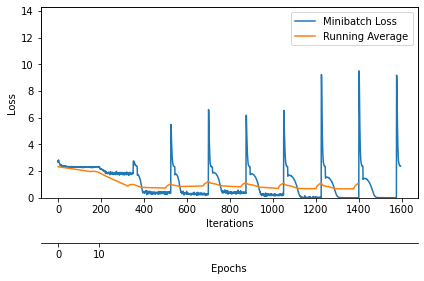

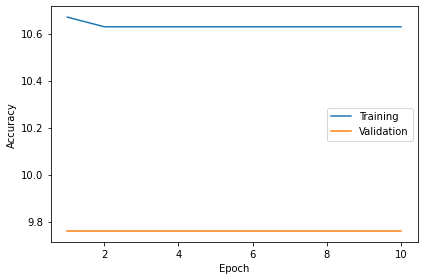

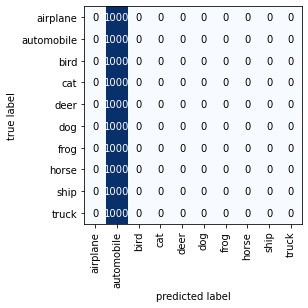

*************************************************************************************
*************************************************************************************

*************************************************************************************
Model: vgg, lr: 0.001
*************************************************************************************
Epoch: 001/010 | Batch 0000/0019 | Loss: 2.3967
Epoch: 001/010 | Train: 10.63% | Validation: 9.76%
Time elapsed: 0.10 min
Self-Supervised | Batch 0000/0156 | Loss: 1.6081
Self-Supervised | Batch 0100/0156 | Loss: 0.0000
Epoch: 002/010 | Batch 0000/0019 | Loss: 50.7179
Epoch: 002/010 | Train: 11.68% | Validation: 11.36%
Time elapsed: 0.46 min
Self-Supervised | Batch 0000/0156 | Loss: 2.2144
Self-Supervised | Batch 0100/0156 | Loss: 0.8650
Epoch: 003/010 | Batch 0000/0019 | Loss: 3.6640
Epoch: 003/010 | Train: 10.63% | Validation: 9.76%
Time elapsed: 0.81 min
Self-Supervised | Batch 0000/0156 | Loss: 1.9360
Self-Supervised | Ba

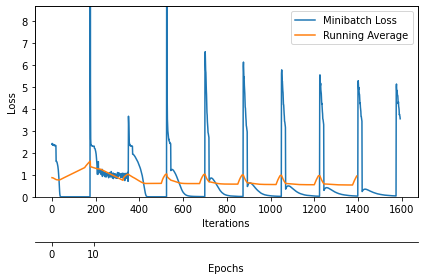

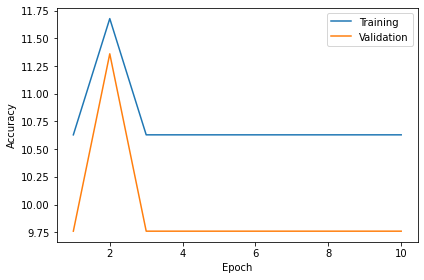

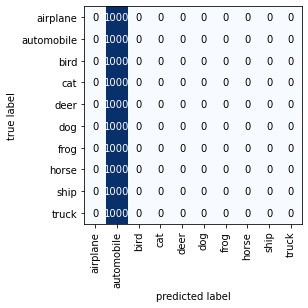

*************************************************************************************
*************************************************************************************

*************************************************************************************
Model: vgg, lr: 0.01
*************************************************************************************
Epoch: 001/010 | Batch 0000/0019 | Loss: 3.5395
Epoch: 001/010 | Train: 10.63% | Validation: 9.76%
Time elapsed: 0.11 min
Self-Supervised | Batch 0000/0156 | Loss: 1.8696
Self-Supervised | Batch 0100/0156 | Loss: 0.0000
Epoch: 002/010 | Batch 0000/0019 | Loss: 12.8815
Epoch: 002/010 | Train: 10.63% | Validation: 9.76%
Time elapsed: 0.45 min
Self-Supervised | Batch 0000/0156 | Loss: 1.2882
Self-Supervised | Batch 0100/0156 | Loss: 0.0015
Epoch: 003/010 | Batch 0000/0019 | Loss: 8.5758
Epoch: 003/010 | Train: 10.63% | Validation: 9.76%
Time elapsed: 0.80 min
Self-Supervised | Batch 0000/0156 | Loss: 0.6314
Self-Supervised | Batc

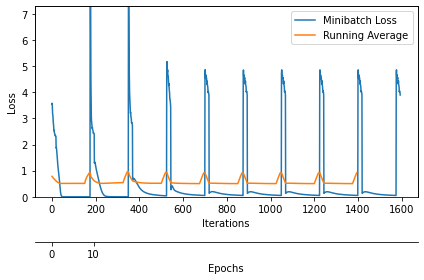

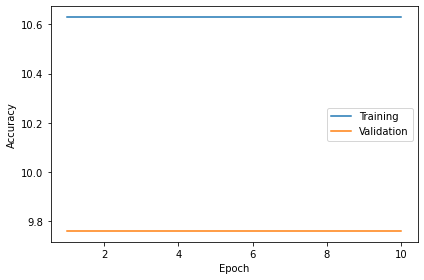

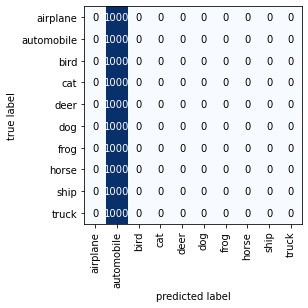

*************************************************************************************
*************************************************************************************

*************************************************************************************
Model: resnet, lr: 0.0001
*************************************************************************************
Epoch: 001/010 | Batch 0000/0019 | Loss: 2.3664
Epoch: 001/010 | Train: 10.86% | Validation: 10.22%
Time elapsed: 0.10 min
Self-Supervised | Batch 0000/0156 | Loss: 1.6353
Self-Supervised | Batch 0100/0156 | Loss: 0.4332
Epoch: 002/010 | Batch 0000/0019 | Loss: 3.4049
Epoch: 002/010 | Train: 10.30% | Validation: 9.50%
Time elapsed: 0.28 min
Self-Supervised | Batch 0000/0156 | Loss: 0.2980
Self-Supervised | Batch 0100/0156 | Loss: 0.1436
Epoch: 003/010 | Batch 0000/0019 | Loss: 3.9604
Epoch: 003/010 | Train: 10.30% | Validation: 9.50%
Time elapsed: 0.46 min
Self-Supervised | Batch 0000/0156 | Loss: 0.1519
Self-Supervised |

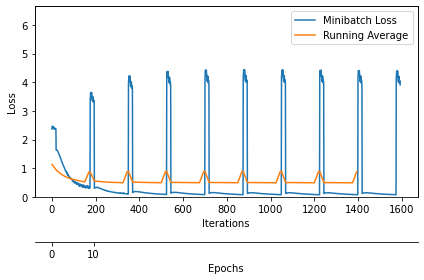

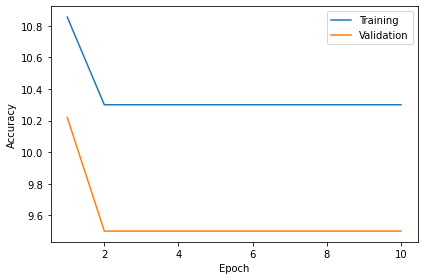

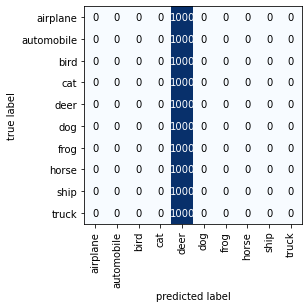

*************************************************************************************
*************************************************************************************

*************************************************************************************
Model: resnet, lr: 0.001
*************************************************************************************
Epoch: 001/010 | Batch 0000/0019 | Loss: 3.7606
Epoch: 001/010 | Train: 16.96% | Validation: 14.68%
Time elapsed: 0.09 min
Self-Supervised | Batch 0000/0156 | Loss: 1.5310
Self-Supervised | Batch 0100/0156 | Loss: 0.2810
Epoch: 002/010 | Batch 0000/0019 | Loss: 4.7280
Epoch: 002/010 | Train: 17.04% | Validation: 16.32%
Time elapsed: 0.28 min
Self-Supervised | Batch 0000/0156 | Loss: 0.9556
Self-Supervised | Batch 0100/0156 | Loss: 0.2368
Epoch: 003/010 | Batch 0000/0019 | Loss: 4.4290
Epoch: 003/010 | Train: 13.98% | Validation: 12.28%
Time elapsed: 0.47 min
Self-Supervised | Batch 0000/0156 | Loss: 0.8267
Self-Supervised 

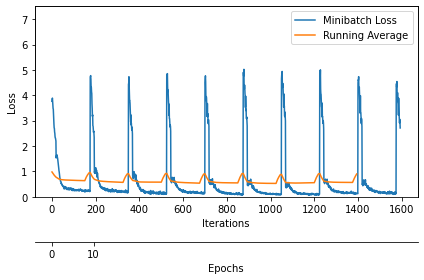

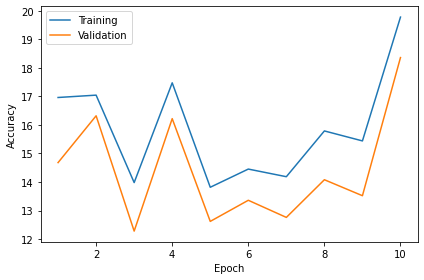

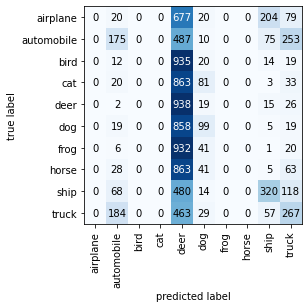

*************************************************************************************
*************************************************************************************

*************************************************************************************
Model: resnet, lr: 0.01
*************************************************************************************
Epoch: 001/010 | Batch 0000/0019 | Loss: 2.5449
Epoch: 001/010 | Train: 30.43% | Validation: 30.40%
Time elapsed: 0.08 min
Self-Supervised | Batch 0000/0156 | Loss: 1.4064
Self-Supervised | Batch 0100/0156 | Loss: 0.4657
Epoch: 002/010 | Batch 0000/0019 | Loss: 4.2330
Epoch: 002/010 | Train: 29.44% | Validation: 29.70%
Time elapsed: 0.26 min
Self-Supervised | Batch 0000/0156 | Loss: 1.2493
Self-Supervised | Batch 0100/0156 | Loss: 0.3847
Epoch: 003/010 | Batch 0000/0019 | Loss: 4.5054
Epoch: 003/010 | Train: 29.83% | Validation: 30.34%
Time elapsed: 0.46 min
Self-Supervised | Batch 0000/0156 | Loss: 0.9703
Self-Supervised |

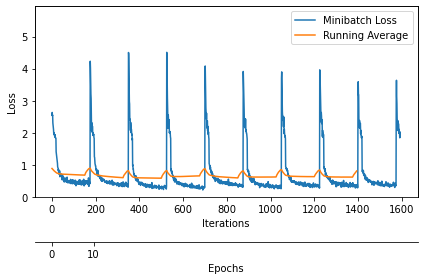

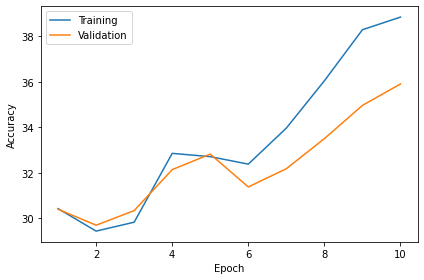

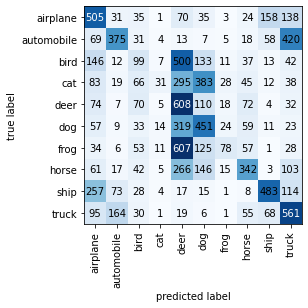

*************************************************************************************
*************************************************************************************

*************************************************************************************
Model: mlp, lr: 0.0001
*************************************************************************************
Epoch: 001/010 | Batch 0000/0019 | Loss: 2.3153
Epoch: 001/010 | Train: 13.55% | Validation: 12.72%
Time elapsed: 0.09 min
Self-Supervised | Batch 0000/0156 | Loss: 2.1785
Self-Supervised | Batch 0100/0156 | Loss: 1.6254
Epoch: 002/010 | Batch 0000/0019 | Loss: 2.8077
Epoch: 002/010 | Train: 10.49% | Validation: 9.58%
Time elapsed: 0.25 min
Self-Supervised | Batch 0000/0156 | Loss: 0.9777
Self-Supervised | Batch 0100/0156 | Loss: 0.1207
Epoch: 003/010 | Batch 0000/0019 | Loss: 5.6844
Epoch: 003/010 | Train: 10.49% | Validation: 9.58%
Time elapsed: 0.40 min
Self-Supervised | Batch 0000/0156 | Loss: 0.2841
Self-Supervised | Ba

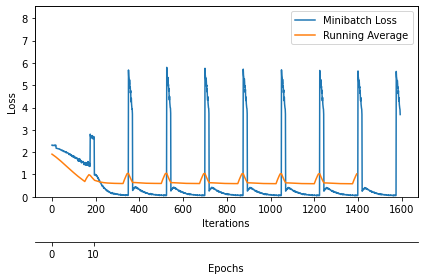

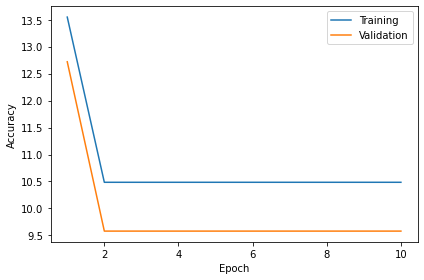

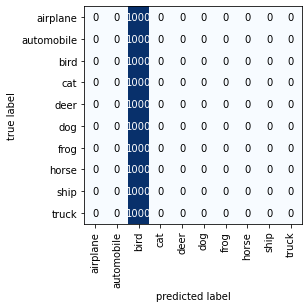

*************************************************************************************
*************************************************************************************

*************************************************************************************
Model: mlp, lr: 0.001
*************************************************************************************
Epoch: 001/010 | Batch 0000/0019 | Loss: 3.7629
Epoch: 001/010 | Train: 10.49% | Validation: 9.58%
Time elapsed: 0.10 min
Self-Supervised | Batch 0000/0156 | Loss: 1.9617
Self-Supervised | Batch 0100/0156 | Loss: 0.0023
Epoch: 002/010 | Batch 0000/0019 | Loss: 11.0018
Epoch: 002/010 | Train: 10.49% | Validation: 9.58%
Time elapsed: 0.23 min
Self-Supervised | Batch 0000/0156 | Loss: 1.9968
Self-Supervised | Batch 0100/0156 | Loss: 0.0050
Epoch: 003/010 | Batch 0000/0019 | Loss: 9.7199
Epoch: 003/010 | Train: 10.49% | Validation: 9.58%
Time elapsed: 0.40 min
Self-Supervised | Batch 0000/0156 | Loss: 1.6042
Self-Supervised | Bat

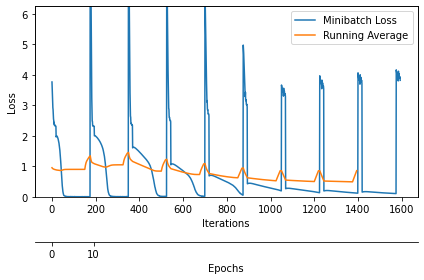

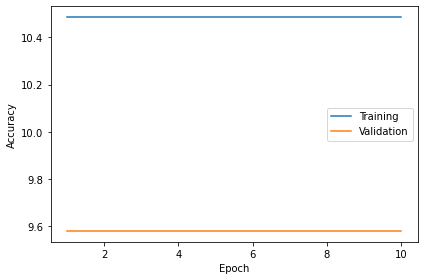

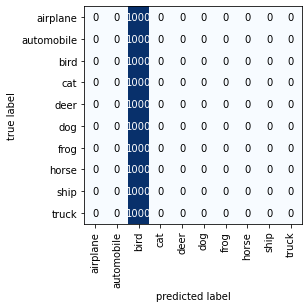

*************************************************************************************
*************************************************************************************

*************************************************************************************
Model: mlp, lr: 0.01
*************************************************************************************
Epoch: 001/010 | Batch 0000/0019 | Loss: 3.9476
Epoch: 001/010 | Train: 10.49% | Validation: 9.58%
Time elapsed: 0.09 min
Self-Supervised | Batch 0000/0156 | Loss: 0.5748
Self-Supervised | Batch 0100/0156 | Loss: 0.0691
Epoch: 002/010 | Batch 0000/0019 | Loss: 5.1648
Epoch: 002/010 | Train: 10.49% | Validation: 9.58%
Time elapsed: 0.24 min
Self-Supervised | Batch 0000/0156 | Loss: 0.1934
Self-Supervised | Batch 0100/0156 | Loss: 0.0830
Epoch: 003/010 | Batch 0000/0019 | Loss: 4.7380
Epoch: 003/010 | Train: 10.49% | Validation: 9.58%
Time elapsed: 0.39 min
Self-Supervised | Batch 0000/0156 | Loss: 0.1393
Self-Supervised | Batch

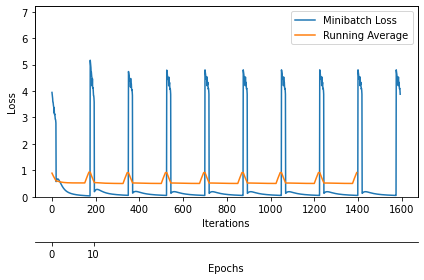

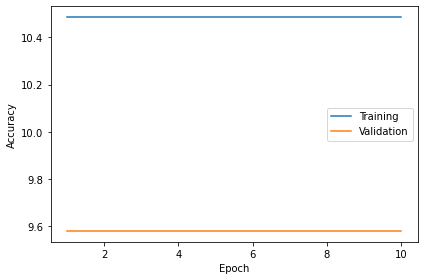

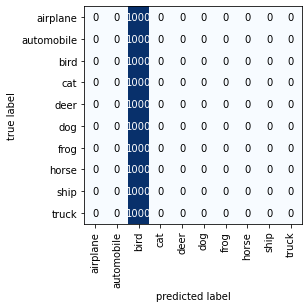

*************************************************************************************
*************************************************************************************



In [8]:
NUM_EPOCHS = 10
for model_name, model in zip(['vgg', 'resnet', 'mlp'],[model_vgg, model_resnet, model_mlp]):
    for lr in [0.0001,0.001,0.01]:
        print("*************************************************************************************")
        print(f"Model: {model_name}, lr: {lr}")
        print("*************************************************************************************")
        if model_name == 'mlp':
            data_loader = [train_labelled_loader_flatten, train_unlabelled_loader_flatten, valid_loader_flatten, test_loader_flatten]
        else:
            data_loader = [train_labelled_loader, train_unlabelled_loader, valid_loader, test_loader]
        val = start_train_selfsupervised(
            model, device, NUM_EPOCHS, data_loader, lr = lr, 
            FileName = f"model_{model_name}_{str(lr).split('.')[-1]}")
        test_acc_lst[model_name].append(val)
        print("*************************************************************************************")
        print("*************************************************************************************")
        print()

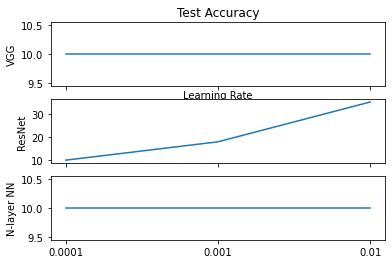

In [10]:
fig, ax = plt.subplots(3, 1, sharex = True)
ax[0].plot(test_acc_lst['vgg'])
ax[1].plot(test_acc_lst['resnet'])
ax[2].plot(test_acc_lst['mlp'])
ax[0].set_xticks(np.arange(3))
ax[0].set_xticklabels([0.0001,0.001,0.01])
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('VGG')
ax[1].set_ylabel('ResNet')
ax[2].set_ylabel('N-layer NN')
ax[0].set_title('Test Accuracy')
plt.show()